## Обучение с нормировкой таргет рейта в 2021

In [3]:
import time
import numpy as np
import pandas as pd
import math
import tqdm
import tqdm.notebook as tqdm_nb
import tqdm.auto as tqdm_a
from termcolor import colored
from functools import partial
from IPython.display import display

import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (f1_score, precision_score, recall_score,
                             roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score
                            )
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.cluster import SpectralClustering
from sklearn.inspection import permutation_importance

import scipy.stats as sps
from catboost import CatBoostClassifier, CatBoostRegressor

### функции для оценки модели

In [4]:
def plot_roc_curve(y, proba, sec_limits=None, label='', color='C0', fig=None, ax=None, return_figure=False):
    fpr, tpr, _ = roc_curve(y, proba)
    area = auc(fpr, tpr)
    
    # fig, ax = check_figax(fig, ax)
    fig.subplots_adjust(hspace=0.1)
    
    ax.plot(fpr, tpr, lw=2, color=color, label=f'{label} auc: {area:.5f}')
    ax.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    
    if sec_limits is None:
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
    else:
        ax.set_xlim(sec_limits[0])
        ax.set_ylim(sec_limits[1])
        
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.set_title('ROC curve', fontsize=15)
    ax.legend(loc='center right', fontsize=12)
    ax.grid()
    
    if return_figure: return fig


def plot_pr_curve(y, proba, sec_limits=None, label='', color='C0', fig=None, ax=None, return_figure=False):
    prec, rec, thres = precision_recall_curve(y, proba)
    area = auc(rec, prec)
    
    # fig, ax = check_figax(fig, ax)
    
    ax.plot(rec, prec, lw=2, color=color, label=f'{label} auc: {area:.5f}')
    
    if sec_limits is None:
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
    else:
        ax.set_xlim(sec_limits[0])
        ax.set_ylim(sec_limits[1])
        
    ax.set_xlabel('Recall', fontsize=14)
    ax.set_ylabel('Precision', fontsize=14)
    ax.set_title('PR curve', fontsize=15)
    ax.legend(loc='center right', fontsize=12)
    ax.grid()
    
    if return_figure: return fig

def plot_confusion(y, pred_label, fig=None, ax=None, return_figure=False, fmt='d'):
    cm = confusion_matrix(y, pred_label)
    
    if ax is None:  # Check if ax is None, and if so, create a new figure and ax.
        fig, ax = plt.subplots(figsize=(8, 8))
        
    ax.set_title('Confusion matrix')
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax, fmt=fmt)
    
    ax.set_xlabel('\nPredicted values')
    ax.set_ylabel('\nActual values')
    
    if return_figure: return fig

def find_best_threshold(y, proba, method='f1'):
    if method == 'f1':
        prec, rec, thres = precision_recall_curve(y, proba, pos_label=1)
        f1 = 2 * prec * rec / (prec + rec)
        ind = np.nanargmax(f1)
        best_thres = thres[ind]
        
    elif method == 'J':
        fpr, tpr, thres = roc_curve(y, proba, pos_label=1)
        J = tpr - fpr
        ind = np.nanargmax(J)
        best_thres = thres[ind]
        
    return best_thres


def predict_proba_4eval_sets(clf, eval_sets):
    target_proba_sets = list()
    lst_feats = clf.feature_names_
    for i in range(len(eval_sets)):
        X, y = eval_sets[i]
        target_proba_sets.append((y, clf.predict_proba(X[lst_feats])[:, 1]))
        
    return target_proba_sets

def get_metrics_clf(target_proba_sets, eval_names, thres_method='f1'):
    n = len(target_proba_sets)
    metrics_df = list()
    
    for i in range(n):
        y, proba = target_proba_sets[i]
        name = eval_names[i]
        best_thres = find_best_threshold(y, proba, thres_method)
        pred_label = np.where(proba > best_thres, 1, 0)
        
        acc = accuracy_score(y, pred_label)
        f1 = f1_score(y, pred_label)
        prec = precision_score(y, pred_label)
        rec = recall_score(y, pred_label)
        roc_auc = roc_auc_score(y, proba)
        metrics_df.append(pd.DataFrame({'sample': [name],
                                        'roc_auc': [roc_auc],
                                        'Best thres': [best_thres],
                                        'F1': [f1],
                                        'Prec': [prec],
                                        'Rec': [rec]}))
    metrics_df = pd.concat(metrics_df, ignore_index=True)
    
    return metrics_df


def evaluation_clf(target_proba_sets, eval_names, roc_limits=None, pr_limits=None, thres_method='f1'):
    n = len(target_proba_sets)
    colors = [f'C{i}' for i in range(n)]
    
    fig, ax = plt.subplots(ncols=2, figsize=(10,4))
    ax1, ax2 = ax.ravel()
    
    metrics_df = get_metrics_clf(target_proba_sets, eval_names)
    
    for i in range(n):
        y, proba = target_proba_sets[i]
        name = eval_names[i]
        color = colors[i]
        
        best_thres = find_best_threshold(y, proba, thres_method)
        pred_label = np.where(proba > best_thres, 1, 0)
        
        plot_roc_curve(y, proba, label=name, color=color, sec_limits=roc_limits, fig=fig, ax=ax1, return_figure=False)
        fig = plot_pr_curve(y, proba, label=name, color=color, sec_limits=pr_limits, fig=fig, ax=ax2, return_figure=True)
        
    return fig, metrics_df



### функции для построения модели и отбора признаков

In [5]:
def build_cb_model(X_train, y_train, X_valid, y_valid, params=None, cat_features=[], 
                   verbose=50, seed=15, n_jobs=-1, fit_kwargs=None, task_type='binary'):
    
    params = {} if params is None else params.copy()
    params['verbose'] = params.get('verbose') or verbose
    params['random_state'] = params.get('random_state') or seed
    params['thread_count'] = params.get('thread_count') or n_jobs
    
    fit_kwargs =  {} if fit_kwargs is None else fit_kwargs.copy()
    
    if task_type == 'binary':
        model = CatBoostClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            cat_features = cat_features,
            **fit_kwargs
        )
        
    elif task_type == 'regression':
        model = CatBoostRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            cat_features = cat_features,
            **fit_kwargs
        )
    else:
        raise ValueError('task should be binary or regression')
        
    return model

def get_feature_importance(model):
    imp = pd.Series(model.feature_importances_,
                   index=model.feature_names_)\
                         .sort_values(ascending=False)\
                         .to_frame()\
                         .reset_index()\
                         .rename(columns={'index': 'feat_name', 0: 'feat_imp'})
    return imp

def plot_feature_importance(model, top_n=None, figsize=None):
    imp = get_feature_importance(model)
    
    fig, ax = plt.subplots(figsize=figsize or (12, 6))
    imp.set_index('feat_name')\
            .sort_values(by='feat_imp')\
            .tail(top_n or len(imp))\
            .plot(kind='barh', color='lightblue', ec='black', ax=ax, width=0.5)
    
    t = f"(Top: {top_n})" if top_n is not None else ""
    ax.set_title("Feature importance " + t)
    ax.grid(False, axis='y')
    
    return fig

def get_permutation_feature_importance(clf, X_test, y_test, scorer, n_repeats=10, seed=15, n_jobs=8, perm_kwargs=None):
    perm_kwargs = {}  if perm_kwargs is None else perm_kwargs.copy()
    perm_kwargs['n_repeats'] = perm_kwargs.get('n_repeats') or n_repeats
    perm_kwargs['random_state'] = perm_kwargs.get('random_state') or seed
    perm_kwargs['n_jobs'] = perm_kwargs.get('n_jobs') or n_jobs
    
    perm_result = permutation_importance(clf, X_test, y_test, scoring=scorer, **perm_kwargs)
    
    perm_imp_df = pd.DataFrame({'feat_name' : clf.feature_names_,
                                'feat_imp' : perm_result['importances_mean'],
                                'feat_imp_std' : perm_result['importances_std']})
    perm_imp_df = perm_imp_df.sort_values(by='feat_imp', ascending=False)\
                                .reset_index(drop=True)
    
    return perm_imp_df


def feat_selection_by_permutation(train_df, test_df, y_train, y_test, lst_feats=None, model_name=None, 
                                 model_params=None, scorer=None, perm_kwargs=None, add_noise_feats=True,
                                 seed=15, n_jobs=-1, fit_kwargs=None):
    model_params = {} if model_params is None else model_params.copy()
    fit_kwargs = {} if fit_kwargs is None else fit_kwargs.copy()
    perm_kwargs = {} if perm_kwargs is None else perm_kwargs.copy()
    
    lst_feats = train_df.columns.to_list() if lst_feats is None else lst_feats.copy()
    lst_cat_feats = [c for c in train_df.select_dtypes(include=['O', 'category']).columns if c in lst_feats]
    
    n_feats = len(lst_feats)
    train_df = train_df.copy()
    tets_df = test_df.copy()
    
    if add_noise_feats:
        train_df['NORMAL'] = sps.norm.rvs(loc=0, scale=1, size=len(train_df), random_state=seed)
        train_df['UNIFORM'] = sps.uniform.rvs(loc=0, scale=1, size=len(train_df), random_state=seed)
        
        test_df['NORMAL'] = sps.norm.rvs(loc=0, scale=1, size=len(test_df), random_state=seed)
        test_df['UNIFORM'] = sps.uniform.rvs(loc=0, scale=1, size=len(test_df), random_state=seed)
        lst_feats += ['NORMAL', 'UNIFORM']
        
    print(f">> Building model: {model_name}")
    start_t = time.time()
    
    if model_name == 'catboost':
        clf = build_cb_model(train_df[lst_feats], y_train, test_df[lst_feats], y_test,
                            cat_features=lst_cat_feats,
                            params=model_params,
                            verbose=0, seed=seed, n_jobs=-1, fit_kwargs=fit_kwargs)
    else:
        raise ValueError('incorrect model name')
        
    end_t = time.time()
    print(f">> Done ({end_t - start_t:.2f}s)")
    
    print(f"Start permutation", "with adding noise feats" if add_noise_feats else "", "...")
    
    perm_imp_df = get_permutation_feature_importance(clf, test_df[lst_feats], y_test, scorer, seed=seed, **perm_kwargs)
    
    if add_noise_feats:
        uniform_perm_value = perm_imp_df[perm_imp_df.feat_name == 'UNIFORM']['feat_imp'].values[0]
        normal_perm_value = perm_imp_df[perm_imp_df.feat_name == 'NORMAL']['feat_imp'].values[0]
        perm_filter = (perm_imp_df.feat_imp <= max(0, normal_perm_value, uniform_perm_value))
        perm_imp_df = perm_imp_df[~perm_filter].reset_index(drop=True)
        train_df.drop(['NORMAL', 'UNIFORM'], axis=1, inplace=True)
        test_df.drop(['NORMAL', 'UNIFORM'], axis=1, inplace=True)
    else:
        perm_filter = (perm_imp_df.feat_imp <= 0)
        perm_imp_df = perm_imp_df[~perm_filter].reset_index(drop=True)
        
    perm_imp_df = perm_imp_df.reset_index(drop=True)
    lst_sel_feats = perm_imp_df['feat_name'].to_list()
    
    end_t = time.time()
    print(f">> Done ({end_t - start_t:.2f}s)")
    print(f"Reduced number of feats: {n_feats} -> {len(lst_sel_feats)}")
    
    return perm_imp_df, lst_sel_feats

def custom_forward_selection(X_train, y_train, X_test, y_test, task_type='binary', eval_sets=None, eval_names=None,
                            lst_feats_for_select=None, cat_features=None, scorer=None, maximize_score=None, maximize_eval_name='Test',
                            metric_thres=1e-5, step=1, method='fast', reorder_init=False, model_name='catboost', model_params=None,
                             seed=15, n_jobs=-1, perm_kwargs=None, fit_kwargs=None):
    
    init_features = X_train.columns.to_list() if lst_feats_for_select is None else lst_feats_for_select
    cat_features = [] if cat_features is None else cat_features
    init_cat_features = [c for c in cat_features if c in set(init_features)]
    
    eval_sets = [(X_train, y_train), (X_test, y_test)] if eval_sets is None else eval_sets
    eval_names = ['Train', 'Test'] if eval_names is None else eval_names
    
    num_fs_steps = len(init_features)
    sign_coef = 1 if maximize_score else -1
    bad_fs_feats = []
    stop_selection_flag = False
    start_i = 0
    sel_features = []
    
    scores = {name : [] for name in eval_names}
    history = dict()
    history['metrics'] = list()
    history['scores'] = list()
    history['num_feats'] = list()
    history['sel_feats'] = list()
    history['iteration'] = list()
    
    progress = tqdm.tqdm(desc='fs_step')
    while not stop_selection_flag:
        excluded_feat = None
        
        n = len(init_features)
        n_iteration = (n + step - 1) // step
        
        for i in range(start_i, n_iteration):
            from_feat_idx = i * step
            to_feat_idx = (i + 1) * step
            feats = init_features[from_feat_idx: to_feat_idx]
            
            sel_features.extend(feats)
            print(sel_features)
            sel_cat_features = [c for c in init_cat_features if c in sel_features]
            
            print(f'--- Iteration: {i}. Number of feats: {to_feat_idx}/{n} ---')
            print(f'>> Building model: {model_name}')
            start_t = time.time()
            
            clf = build_cb_model(X_train[sel_features], y_train, 
                                     X_test[sel_features], y_test,
                                     cat_features=sel_cat_features, params=model_params,
                                     verbose=0, seed=seed, n_jobs=n_jobs, fit_kwargs=None)
            
            target_proba_sets = predict_proba_4eval_sets(clf, eval_sets)
            metrics_df = get_metrics_clf(target_proba_sets, eval_names=eval_names)
            display(metrics_df)
            
            for eval_samp, eval_name in zip(eval_sets, eval_names):
                score = scorer(clf, eval_samp[0][clf.feature_names_], eval_samp[1])
                scores[eval_name].append(score)
                
            end_t = time.time()
            print(f'>> Done ({end_t  - start_t:.2f}s)')
            
            if i > start_i:
                prev_valid = scores[maximize_eval_name][-2]
                curr_valid = scores[maximize_eval_name][-1]
                d_valid = sign_coef * (curr_valid - prev_valid)
                
                if (d_valid <= metric_thres):
                    print('>> Excluded:', feats)
                    print(*[f'>> score increase_{name}: {sign_coef*np.diff(scores[name][-2:])[0]:.3f}' for name in eval_names], sep='\n')
                    
                    new_init_features = [c for c in init_features if c not in set(feats)]
                    new_init_cat_features = [c for c in cat_features if c in set(new_init_features)]
                    
                    if reorder_init:
                        clf = build_cb_model(X_train[new_init_features], y_train,
                                                 X_test[new_init_features], y_test,
                                                 cat_features=new_init_cat_features, params=model_params,
                                                 verbose=0, seed=seed,  n_jobs=n_jobs, fit_kwargs=None)
                        start_t = time.time()
                        print(f'>> Start sorted features after excluding. Method: {method}')
                        if method == 'fast':
                            new_init_sorted_features = get_feature_importance(clf)['feat_name'].to_list()
                        elif method == 'permutation':
                            new_init_sorted_features = get_permutation_feature_importance(clf, X_test[new_init_features],
                                                                                          y_test, scorer)['feat_name'].to_list()
                            
                    init_features = new_init_sorted_features.copy() if reorder_init else new_init_features.copy()
                    init_cat_features = [c for c in cat_features if c in set(init_features)]
                    
                    excluded_feat = feats
                    bad_fs_feats.extend(excluded_feat)
                    
                    end_t = time.time()
                    print(f'>> Done ({end_t - start_t:.2f}s)')
                    break
                    
            history['metrics'].append(metrics_df)
            history['scores'].append(scores)
            history['num_feats'].append(len(sel_features))
            history['sel_feats'].append(sel_features.copy())
            history['iteration'].append(i)
                                        
        if excluded_feat is None:
            stop_selection_flag = True
        else:
            if reorder_init:
                start_i = 0
                sel_features = []
                scores = {name: [] for name in eval_names}
                history = dict()
                history['metrics'] = list()
                history['scores'] = list()
                history['num_feats'] = list()
                history['sel_feats'] = list()
                history['iteration'] = list()                     
            else:
                start_i = from_feat_idx
                sel_features = init_features[:start_i]                       

        progress.update()
        print('*'*50)
    print(f'>> Finish. Number of features in final subset: {len(sel_features)}')

    return(history)

In [6]:
df = pd.read_csv('train_dataset_Самолет.csv')

C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_23228\1363469232.py:1: DtypeWarning: Columns (51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,131,132,133,135,136,139,140,141,142,143,144,145,146,147,148,149,151,152,155,156,157,158,159,160,161,163,164,165,167,168,169,171,172,173,174,175,176,177,178,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,223,224,227,239,240,241,242,243,244,245,246,459,460,461,467,468,469,515,516,523,524,531,532,539,540,547,548,555,556,563,564,565,567,571,572,573,575,579,580,581,582,583,587,588,595,596,603,604,611,612,613,615,795,796,797,799,821,822,825,826,1031,1032,1033,1034,1035,1036,1037,1039,1040,1041,1042,1043,1044,1045,1047,1048,1049,1050,1051,1052,1055,1056,1057,1058,1059,1060,1063,1064,1065,1067,1068,1069,1072,1073,1074,1075,1076,1077,1078,1172,1173,1174,1176,1177,1178,1179,1180,1181,1182,1275,1276,1277,1278,1279,1280,1281,

### график таргет рейта по месяцам

In [9]:
df.report_date = pd.to_datetime(df.report_date)

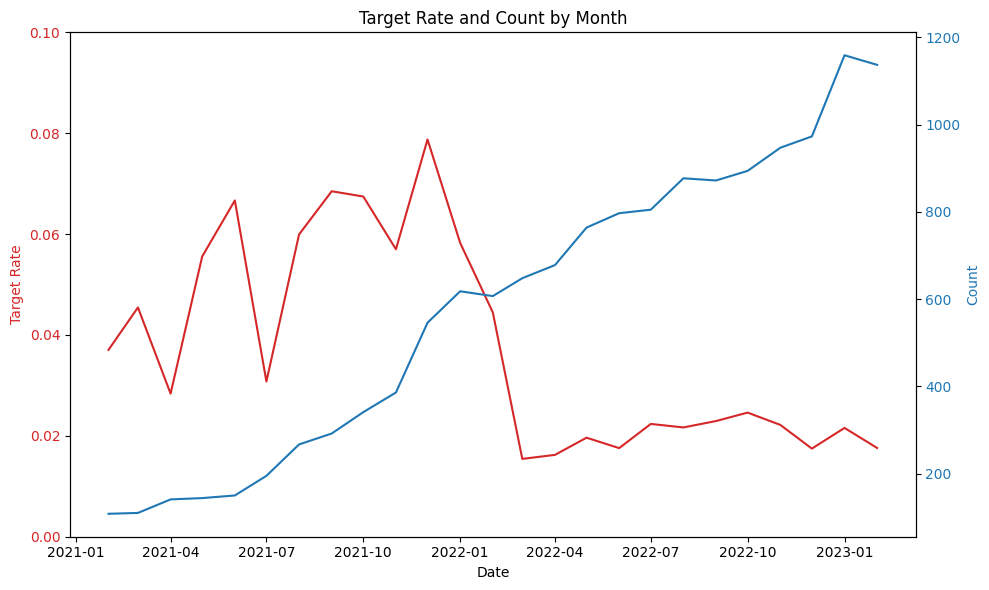

In [10]:
df['year_month'] = df['report_date'].dt.to_period('M')

# Group by month and year
grouped = df.groupby('year_month').agg(
    target_rate=('target', 'mean'),
    count=('target', 'size')
)

grouped.index = grouped.index.astype('datetime64[ns]')
fig, ax1 = plt.subplots(figsize=(10, 6))


# Plot target rate on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylim([0, 0.1])
ax1.set_ylabel('Target Rate', color=color)
ax1.plot(grouped.index, grouped['target_rate'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create another y-axis for the count
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Count', color=color)
ax2.plot(grouped.index, grouped['count'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Target Rate and Count by Month')
plt.tight_layout()
plt.show()

### нормировка таргет рейта, чтобы данные в 2021 и 2022 году не различались

In [11]:
tmp = df[(df.report_date > '2022-02-01')]

tmp1 = df[(df.report_date == '2021-02-01')]
percent_to_remove = 0.4
mask = tmp1['target'] == 1
indices_to_remove = tmp1[mask].sample(frac=percent_to_remove).index
tmp1 = tmp1.drop(indices_to_remove)

tmp2 = df[(df.report_date == '2021-03-01')]
percent_to_remove = 0.55
mask = tmp2['target'] == 1
indices_to_remove = tmp2[mask].sample(frac=percent_to_remove).index
tmp2 = tmp2.drop(indices_to_remove)

tmp3 = df[(df.report_date == '2021-04-01') | (df.report_date == '2021-07-01')]
percent_to_remove = 0.2
mask = tmp3['target'] == 1
indices_to_remove = tmp3[mask].sample(frac=percent_to_remove).index
tmp3 = tmp3.drop(indices_to_remove)

tmp4 = df[(df.report_date == '2021-05-01') | (df.report_date == '2021-06-01')]
percent_to_remove = 0.6
mask = tmp4['target'] == 1
indices_to_remove = tmp4[mask].sample(frac=percent_to_remove).index
tmp4 = tmp4.drop(indices_to_remove)

tmp5 = df[(df.report_date == '2021-08-01') | (df.report_date == '2021-09-01') \
          | (df.report_date == '2021-10-01') | (df.report_date == '2021-11-01')]
percent_to_remove = 0.7
mask = tmp5['target'] == 1
indices_to_remove = tmp5[mask].sample(frac=percent_to_remove).index
tmp5 = tmp5.drop(indices_to_remove)

tmp6 = df[(df.report_date == '2021-12-01')]
percent_to_remove = 0.7
mask = tmp6['target'] == 1
indices_to_remove = tmp6[mask].sample(frac=percent_to_remove).index
tmp6 = tmp6.drop(indices_to_remove)

In [12]:
new_df = pd.concat([tmp, tmp1, tmp2, tmp3, tmp4, tmp5, tmp6], axis = 0)

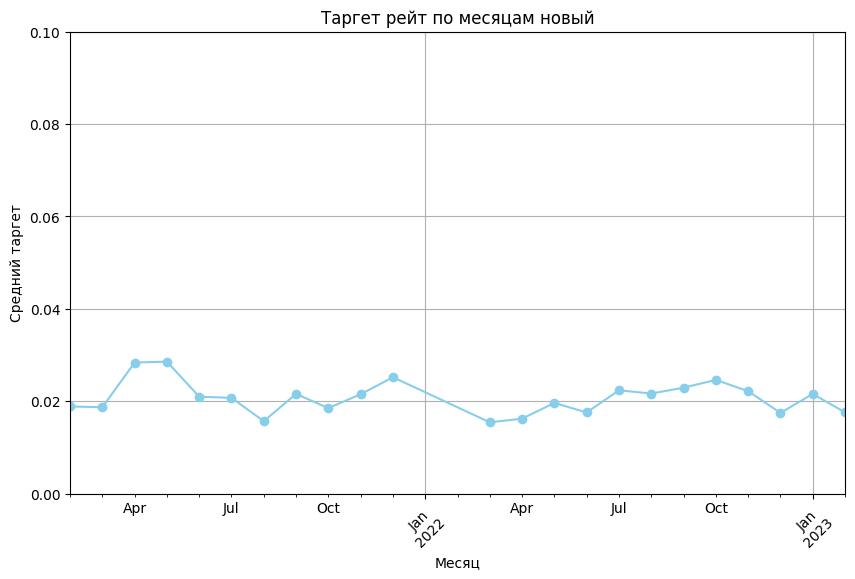

In [13]:
monthly_target = new_df.groupby(new_df['report_date'].dt.to_period('M'))['target'].mean()

plt.figure(figsize=(10, 6))
monthly_target.plot(kind='line', marker='o', color='skyblue')
plt.ylim([0, 0.1])
plt.xlabel('Месяц')
plt.ylabel('Средний таргет')
plt.title('Таргет рейт по месяцам новый')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [14]:
print(f"Размер выборки с изначальным таргет рейтом: {df.shape[0]}")
print(f"Размер выборки с новым таргет рейтом: {new_df.shape[0]}")

Размер выборки с изначальным таргет рейтом: 14456
Размер выборки с новым таргет рейтом: 13126


### убираем фичи незаполненные на >95% и с корреляцией >90%

In [15]:
df = new_df.copy()

In [16]:
ignore_features = ['report_date', 'client_id', 'target', 'year_month']

In [17]:
nan_percentage = df.isna().mean()
cols_to_drop = nan_percentage[nan_percentage > 0.95].index
df_cleaned = df.drop(columns=cols_to_drop)

In [18]:
len(cols_to_drop)

1687

In [19]:
df_cleaned.shape

(13126, 980)

In [20]:
def get_correlated_feats(corr_matrix, feat_stats, greater_is_better=True, corr_threshold=0.9):
    cols = corr_matrix.columns.to_list()
    dropped = {col:0 for col in cols}
    for col in tqdm.tqdm(cols, desc='Get correlated features'):
        if dropped[col] == 0:
            columns_to_check = corr_matrix.index.values[np.abs(corr_matrix[col]) >= corr_threshold]
            if len(columns_to_check) > 1:
                print(f'{col} -> {columns_to_check}')
                if feat_stats is None:
                    bad_cols = columns_to_check[1:]
                else:
                    sel_stats = feat_stats.loc[columns_to_check]
                    if greater_is_better:
                        bad_cond = np.abs(sel_stats) < np.abs(sel_stats).max()
                    else:
                        bad_cond = np.abs(sel_stats) > np.abs(sel_stats).min()
                        
                    bad_cols = sel_stats[bad_cond].index.to_list()
                    norm_cols = sel_stats[~bad_cond].index.to_list()
                    if len(norm_cols) > 1:
                        for norm_col in norm_cols[1:]:
                            dropped[norm_col] += 1
                            
                for bad_col in bad_cols:
                    dropped[bad_col] += 1
                
    high_corr_cols = [c for c in dropped.keys() if dropped[c] > 0]
    return high_corr_cols

In [21]:
corr_mx = df_cleaned.drop(columns=ignore_features).corr()

C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_23228\2432034929.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mx = df_cleaned.drop(columns=ignore_features).corr()


In [22]:
corr_feats = get_correlated_feats(corr_mx, feat_stats=nan_percentage, greater_is_better=False, corr_threshold=0.9)

Get correlated features: 100%|█████████████████████████████████████████████████████| 932/932 [00:00<00:00, 5561.53it/s]

col280 -> ['col280' 'col320']
col284 -> ['col284' 'col324']
col288 -> ['col288' 'col292' 'col328']
col296 -> ['col292' 'col296']
col300 -> ['col300' 'col340']
col304 -> ['col304' 'col344']
col308 -> ['col308' 'col312' 'col348']
col316 -> ['col312' 'col316']
col320 -> ['col280' 'col320']
col324 -> ['col284' 'col324']
col328 -> ['col288' 'col328' 'col332']
col340 -> ['col300' 'col340']
col344 -> ['col304' 'col344']
col348 -> ['col308' 'col348' 'col352']
col388 -> ['col388' 'col392']
col396 -> ['col392' 'col396']
col408 -> ['col408' 'col412']
col420 -> ['col420' 'col428']
col448 -> ['col448' 'col452']
col474 -> ['col474' 'col475' 'col482' 'col483' 'col484' 'col486' 'col490' 'col491']
col476 -> ['col475' 'col476' 'col484']
col478 -> ['col478' 'col482' 'col483' 'col486']
col487 -> ['col475' 'col482' 'col483' 'col484' 'col486' 'col487' 'col488' 'col490'
 'col491']
col492 -> ['col482' 'col483' 'col484' 'col486' 'col488' 'col490' 'col491' 'col492']
col494 -> ['col494' 'col495' 'col496' 'col502

In [23]:
len(corr_feats)

501

In [24]:
df_no_corr = df_cleaned.drop(columns=corr_feats)
df_no_corr.shape

(13126, 479)

### убираем категориальные фичи по жакардовой близости

In [25]:
df_new = df_no_corr.copy()
df_new['report_date'] = df_new['report_date'].astype('datetime64[ns]')
df_new = df_new.sort_values(by='report_date')

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

def compare_columns(df):
    columns = df.columns
    results = pd.DataFrame(index=columns, columns=columns)

    for col1 in tqdm.tqdm(columns):
        for col2 in columns:
            set1 = set(df[col1].dropna().unique())
            set2 = set(df[col2].dropna().unique())
            results.loc[col1, col2] = jaccard_similarity(set1, set2)

    return results

cat_columns = df_new.select_dtypes('object')
compare_df = compare_columns(cat_columns)

def get_unique_columns(similarity_matrix, threshold=0.26):

    columns_to_remove = set()
    for i in range(similarity_matrix.shape[0]):
        for j in range(i+1, similarity_matrix.shape[1]):
            if isinstance(similarity_matrix, np.ndarray):
                value = similarity_matrix[i, j]
            else:  # Если это DataFrame
                value = similarity_matrix.iloc[i, j]
            if value >= threshold:
                columns_to_remove.add(j)

    # Получить названия удаленных колонок (если это DataFrame)
    if isinstance(similarity_matrix, pd.DataFrame):
        removed_column_names = [similarity_matrix.columns[i] for i in columns_to_remove]

    # Удалить дублирующиеся колонки из матрицы
    if isinstance(similarity_matrix, np.ndarray):
        updated_matrix = np.delete(similarity_matrix, list(columns_to_remove), axis=1)
        updated_matrix = np.delete(updated_matrix, list(columns_to_remove), axis=0)
    else:  # Если это DataFrame
        updated_matrix = similarity_matrix.drop(similarity_matrix.columns[list(columns_to_remove)], axis=1)
        updated_matrix = updated_matrix.drop(similarity_matrix.index[list(columns_to_remove)], axis=0)

    return updated_matrix

mat = get_unique_columns(compare_df)

100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 20.96it/s]


In [26]:
len(mat.columns.values)

18

### делим на train/valid/test по методике OOT; данные берем за весь период

In [27]:
model_df = df_new.copy()

In [28]:
train_mask = model_df.report_date <= '2022-09-01'
valid_mask = (model_df.report_date > '2022-09-01') & (model_df.report_date <= '2023-01-01')
oot_mask = model_df.report_date > '2023-01-01'

model_df.loc[train_mask, 'sample'] = 'Train'
model_df.loc[valid_mask, 'sample'] = 'Valid(OOT)'
model_df.loc[oot_mask, 'sample'] = 'Test(OOT)'

In [29]:
def get_samp_descr_for_binary_task(df, sample_col, date_col, target_col, feature_cols):
    sample_names = df[sample_col].unique()
    for name in sample_names:
        samp = df[df[sample_col] == name]
        print(colored(f'{name:}', None, attrs=['bold']))
        print('Period from:', samp[date_col].dt.date.min(), 'to', samp[date_col].dt.date.max())
        print('Target rate:', round(samp[target_col].mean(), 6))
        print('Count of target 1:', samp[target_col].sum())
        print('Shape of sample:', samp[feature_cols].shape)
        print('--------------------------------------------------------------------')

In [30]:
sample = 'sample'
target = 'target'
report_date = 'report_date'

In [31]:
nums = df_new.select_dtypes(include=['int64', 'float64']).columns.tolist()
cats = list(set(mat.columns.to_list() + df_new.select_dtypes(include=['O']).columns.tolist()))

ignore_features = ['report_date', 'client_id', 'target', 'year_month', 'sample', 'col1454']
cat_features = [c for c in cats if c not in ignore_features]
cols = [c for c in nums if c not in ignore_features] + cat_features

In [32]:
get_samp_descr_for_binary_task(model_df, sample_col=sample, date_col=report_date, target_col=target, feature_cols=cols)

Train
Period from: 2021-02-01 to 2022-09-01
Target rate: 0.020334
Count of target 1: 163
Shape of sample: (8016, 474)
--------------------------------------------------------------------
Valid(OOT)
Period from: 2022-10-01 to 2023-01-01
Target rate: 0.021394
Count of target 1: 85
Shape of sample: (3973, 474)
--------------------------------------------------------------------
Test(OOT)
Period from: 2023-02-01 to 2023-02-01
Target rate: 0.01759
Count of target 1: 20
Shape of sample: (1137, 474)
--------------------------------------------------------------------


### построение базовой модели, отбор незначимых признаков (feature importance == 0)

In [33]:
model_df[cat_features] = model_df[cat_features].fillna('unknown')

In [34]:
for col in cat_features:
    model_df[col] = model_df[col].astype(str)

In [35]:
catboost_params = {
    'iterations': 200,
    'learning_rate': 0.01,
    'depth': 6,
    'eval_metric': 'AUC',
    # 'class_weights': [1, (2296 / 45)]
}

In [386]:
clf = build_cb_model(model_df[train_mask][cols], model_df[train_mask].target,
                     model_df[valid_mask][cols], model_df[valid_mask].target, 
                     cat_features=cat_features, params=catboost_params)

0:	test: 0.5553816	best: 0.5553816 (0)	total: 69ms	remaining: 13.7s
50:	test: 0.6908088	best: 0.6952387 (44)	total: 3.72s	remaining: 10.9s
100:	test: 0.7118404	best: 0.7126573 (99)	total: 7.16s	remaining: 7.02s
150:	test: 0.7494523	best: 0.7497579 (149)	total: 10.7s	remaining: 3.49s
199:	test: 0.7820927	best: 0.7820927 (199)	total: 14.3s	remaining: 0us

bestTest = 0.7820927136
bestIteration = 199



,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.843361,0.080787,0.373832,0.784314,0.245399
1,Valid(OOT),0.782093,0.062704,0.180451,0.132597,0.282353


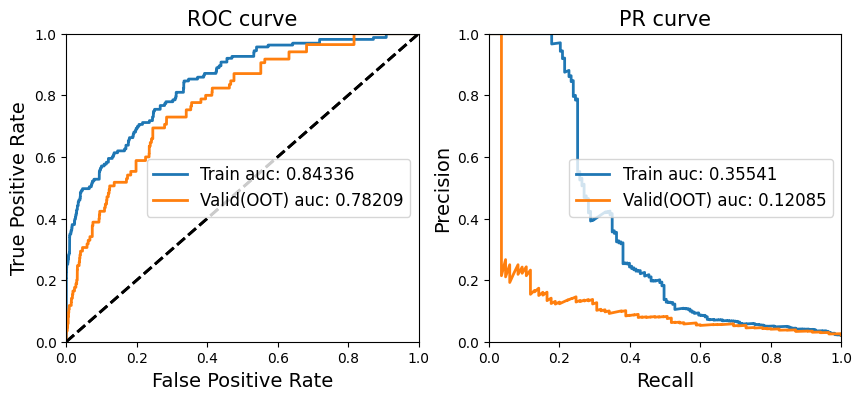

In [387]:
target_proba_sets = predict_proba_4eval_sets(clf, [(model_df[train_mask][cols], model_df[train_mask].target),
                     (model_df[valid_mask][cols], model_df[valid_mask].target)])

fig, metrics_df = evaluation_clf(target_proba_sets, ['Train', 'Valid(OOT)'], thres_method='J')

display(metrics_df)

In [389]:
imp = get_feature_importance(clf)

In [390]:
zero_imp = imp[imp.feat_imp == 0.0].feat_name.values

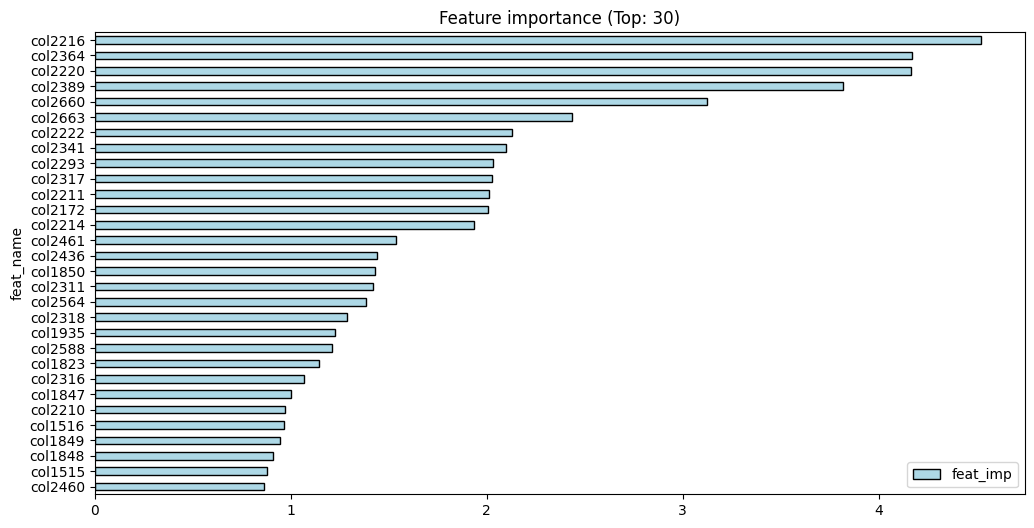

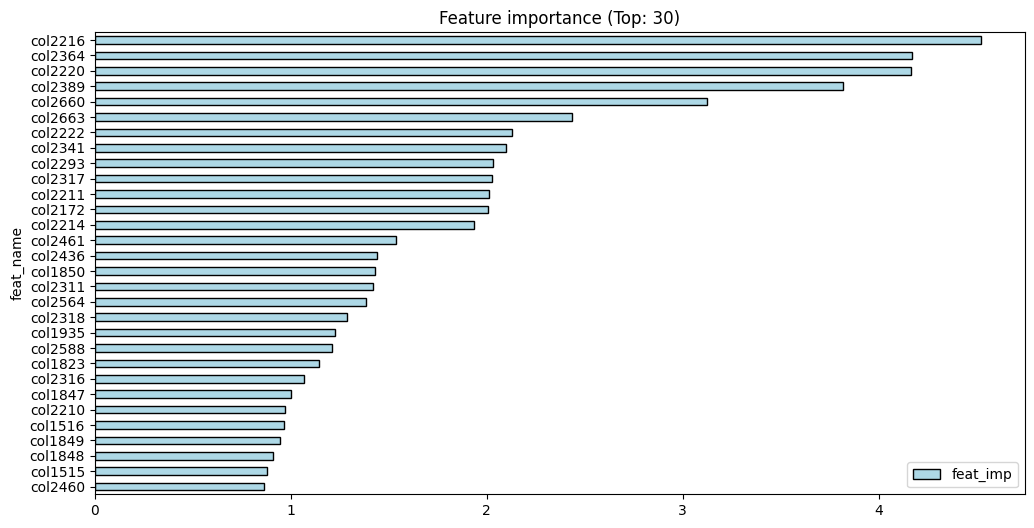

In [391]:
plot_feature_importance(clf, top_n=30)

In [392]:
model_df = model_df.drop(columns=zero_imp)

### отбор по отрицательному permutation importance

In [393]:
cols = model_df.drop(columns=ignore_features).columns.to_list()
cat_features = model_df[cols].select_dtypes(include=['object']).columns.tolist()

In [394]:
clf = build_cb_model(model_df[train_mask][cols], model_df[train_mask].target,
                     model_df[valid_mask][cols], model_df[valid_mask].target, 
                     cat_features=cat_features, params=catboost_params)

0:	test: 0.5779155	best: 0.5779155 (0)	total: 52.3ms	remaining: 10.4s
50:	test: 0.6992239	best: 0.7030486 (42)	total: 2.94s	remaining: 8.58s
100:	test: 0.7402899	best: 0.7419753 (99)	total: 5.9s	remaining: 5.79s
150:	test: 0.7717108	best: 0.7722343 (148)	total: 9.07s	remaining: 2.94s
199:	test: 0.7889948	best: 0.7898269 (195)	total: 12s	remaining: 0us

bestTest = 0.7898269184
bestIteration = 195

Shrink model to first 196 iterations.


last_num_feats = len(model_df[cols])  # starting with all features
convergence = False

while not convergence:
    perm_imp_df, lst_sel_feats = feat_selection_by_permutation(
        model_df[cols][train_mask], model_df[cols][valid_mask], 
        model_df[train_mask].target, model_df[valid_mask].target, lst_feats=cols, 
        model_name='catboost', model_params=catboost_params, scorer='roc_auc')
    
    if len(lst_sel_feats) == last_num_feats:
    # if len(lst_sel_feats) < 30:
        convergence = True
    else:
        last_num_feats = len(lst_sel_feats)
        cols = lst_sel_feats 


In [395]:
perm_imp_df, lst_sel_feats = feat_selection_by_permutation(
    model_df[cols][train_mask], model_df[cols][valid_mask], 
    model_df[train_mask].target, model_df[valid_mask].target, lst_feats=cols, 
    model_name='catboost', model_params=catboost_params, scorer='roc_auc')

>> Building model: catboost
>> Done (12.16s)
Start permutation with adding noise feats ...
>> Done (29.40s)
Reduced number of feats: 279 -> 39


In [437]:
lst_sel_feats

['col2663',
 'col2220',
 'col2222',
 'col2341',
 'col2389',
 'col2660',
 'col2292',
 'col2311',
 'col2436',
 'col2461',
 'col2308',
 'col2318',
 'col2317',
 'col2364',
 'col2014',
 'col644',
 'col2460',
 'col2293',
 'col2038',
 'col2312',
 'col2221',
 'col340',
 'col2214',
 'col2588',
 'col2244',
 'col2216',
 'col1968',
 'col2190',
 'col2182',
 'col2168',
 'col2174',
 'col1827',
 'col2211',
 'col808',
 'col772',
 'col620',
 'col2210',
 'col2171',
 'col2170']

In [396]:
cols = lst_sel_feats.copy()
cat_features = model_df[cols].select_dtypes(include=['object']).columns.tolist()

In [397]:
clf = build_cb_model(model_df[train_mask][cols], model_df[train_mask].target,
                     model_df[valid_mask][cols], model_df[valid_mask].target, 
                     cat_features=cat_features, params=catboost_params)

0:	test: 0.6864833	best: 0.6864833 (0)	total: 5.27ms	remaining: 1.05s
50:	test: 0.8011877	best: 0.8108388 (1)	total: 240ms	remaining: 700ms
100:	test: 0.8029608	best: 0.8108388 (1)	total: 465ms	remaining: 456ms
150:	test: 0.8150645	best: 0.8150645 (150)	total: 682ms	remaining: 221ms
199:	test: 0.8252527	best: 0.8258427 (194)	total: 895ms	remaining: 0us

bestTest = 0.8258427136
bestIteration = 194

Shrink model to first 195 iterations.


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.881095,0.085770,0.404412,0.504587,0.337423
1,Valid(OOT),0.825843,0.064177,0.218750,0.148936,0.411765


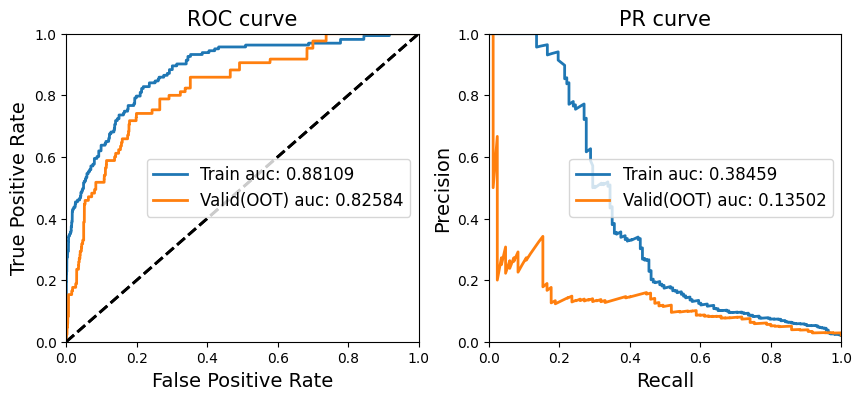

In [398]:
target_proba_sets = predict_proba_4eval_sets(clf, [(model_df[train_mask][cols], model_df[train_mask].target),
                     (model_df[valid_mask][cols], model_df[valid_mask].target)])

fig, metrics_df = evaluation_clf(target_proba_sets, ['Train', 'Valid(OOT)'], thres_method='f1')

display(metrics_df)

y_pred = clf.predict(model_df[valid_mask][cols])
plot_confusion(model_df[valid_mask].target, y_pred)

### отбор с помощью forward selection, критерий - permutation importance

In [400]:
def custom_auc_scorer(model, X, y_true):
    y_pred = model.predict_proba(X)[:, 1] # Assuming binary classification
    return roc_auc_score(y_true, y_pred)

In [401]:
history = custom_forward_selection(model_df[train_mask][cols], model_df[train_mask].target,
                     model_df[valid_mask][cols], model_df[valid_mask].target, eval_sets=[(model_df[train_mask][cols], model_df[train_mask].target), (model_df[valid_mask][cols], model_df[valid_mask].target)], eval_names=['Train', 'Valid(OOT)'],
                     lst_feats_for_select=cols, cat_features=cat_features, scorer=custom_auc_scorer, method='permutation', model_params=catboost_params, maximize_eval_name='Valid(OOT)')

fs_step: 0it [00:00, ?it/s]

['col2663']
--- Iteration: 0. Number of feats: 1/39 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.691203,0.148234,0.116317,0.078947,0.220859
1,Valid(OOT),0.823106,0.144177,0.141304,0.079877,0.611765


>> Done (0.76s)
['col2663', 'col2220']
--- Iteration: 1. Number of feats: 2/39 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_26160\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)
C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_26160\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.763591,0.279240,0.140845,0.130208,0.153374
1,Valid(OOT),0.833792,0.258164,0.211091,0.124473,0.694118


fs_step: 1it [00:01,  1.61s/it]

>> Done (0.85s)
>> Excluded: ['col2220']
>> score increase_Train: -0.072
>> score increase_Valid(OOT): -0.011
>> Done (0.86s)
**************************************************
['col2663', 'col2222']
--- Iteration: 1. Number of feats: 2/38 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_26160\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.749567,0.282295,0.127090,0.139706,0.116564
1,Valid(OOT),0.830236,0.258975,0.194444,0.121037,0.494118


>> Done (0.82s)
['col2663', 'col2222', 'col2341']
--- Iteration: 2. Number of feats: 3/38 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_26160\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.793272,0.218641,0.189542,0.202797,0.177914
1,Valid(OOT),0.840207,0.194670,0.226506,0.142424,0.552941


fs_step: 2it [00:03,  1.62s/it]

>> Done (0.82s)
>> Excluded: ['col2341']
>> score increase_Train: -0.044
>> score increase_Valid(OOT): -0.010
>> Done (0.82s)
**************************************************
['col2663', 'col2222', 'col2389']
--- Iteration: 2. Number of feats: 3/37 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_26160\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.796102,0.233951,0.198413,0.280899,0.153374
1,Valid(OOT),0.857158,0.210537,0.288066,0.221519,0.411765


>> Done (0.84s)
['col2663', 'col2222', 'col2389', 'col2660']
--- Iteration: 3. Number of feats: 4/37 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_26160\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.806516,0.455126,0.197333,0.174528,0.226994
1,Valid(OOT),0.862474,0.456050,0.251121,0.202899,0.329412


fs_step: 3it [00:04,  1.65s/it]

>> Done (0.84s)
>> Excluded: ['col2660']
>> score increase_Train: -0.010
>> score increase_Valid(OOT): -0.005
>> Done (0.84s)
**************************************************
['col2663', 'col2222', 'col2389', 'col2292']
--- Iteration: 3. Number of feats: 4/36 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_26160\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.807717,0.458031,0.221402,0.277778,0.184049
1,Valid(OOT),0.870425,0.455825,0.283105,0.231343,0.364706


>> Done (0.87s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2311']
--- Iteration: 4. Number of feats: 5/36 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_26160\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.893289,0.098019,0.378571,0.452991,0.325153
1,Valid(OOT),0.871476,0.098213,0.240964,0.246914,0.235294


fs_step: 4it [00:06,  1.68s/it]

>> Done (0.85s)
>> Excluded: ['col2311']
>> score increase_Train: -0.086
>> score increase_Valid(OOT): -0.001
>> Done (0.85s)
**************************************************
['col2663', 'col2222', 'col2389', 'col2292', 'col2436']
--- Iteration: 4. Number of feats: 5/35 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_26160\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.877716,0.104498,0.386207,0.440945,0.343558
1,Valid(OOT),0.850582,0.088364,0.285714,0.230216,0.376471


>> Done (0.86s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461']
--- Iteration: 5. Number of feats: 6/35 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_26160\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.823559,0.333551,0.252174,0.432836,0.177914
1,Valid(OOT),0.844755,0.309731,0.228374,0.161765,0.388235


>> Done (0.83s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2308']
--- Iteration: 6. Number of feats: 7/35 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_26160\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.883906,0.087544,0.378531,0.350785,0.411043
1,Valid(OOT),0.849110,0.085873,0.270270,0.218978,0.352941


fs_step: 5it [00:09,  2.00s/it]

>> Done (0.88s)
>> Excluded: ['col2308']
>> score increase_Train: -0.060
>> score increase_Valid(OOT): -0.004
>> Done (0.88s)
**************************************************
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318']
--- Iteration: 6. Number of feats: 7/34 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_26160\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.888861,0.086588,0.404692,0.387640,0.423313
1,Valid(OOT),0.855621,0.080057,0.297872,0.233333,0.411765


>> Done (0.85s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317']
--- Iteration: 7. Number of feats: 8/34 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.899833,0.089292,0.431095,0.508333,0.374233
1,Valid(OOT),0.853726,0.064844,0.276119,0.202186,0.435294


>> Done (0.83s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364']
--- Iteration: 8. Number of feats: 9/34 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_26160\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.892447,0.079828,0.411392,0.424837,0.398773
1,Valid(OOT),0.852813,0.072452,0.294372,0.232877,0.400000


>> Done (0.83s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014']
--- Iteration: 9. Number of feats: 10/34 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_26160\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.809926,0.445211,0.255605,0.201413,0.349693
1,Valid(OOT),0.845239,0.443224,0.206731,0.129909,0.505882


>> Done (0.88s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644']
--- Iteration: 10. Number of feats: 11/34 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_26160\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.852253,0.197348,0.332248,0.354167,0.312883
1,Valid(OOT),0.841049,0.184376,0.228916,0.153846,0.447059


>> Done (0.92s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460']
--- Iteration: 11. Number of feats: 12/34 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.877504,0.123440,0.401709,0.661972,0.288344
1,Valid(OOT),0.840916,0.066123,0.259542,0.192090,0.400000


>> Done (0.82s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2293']
--- Iteration: 12. Number of feats: 13/34 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_26160\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.837543,0.339614,0.285714,0.320611,0.257669
1,Valid(OOT),0.843926,0.336585,0.229965,0.163366,0.388235


fs_step: 6it [00:15,  3.35s/it]

>> Done (0.87s)
>> Excluded: ['col2293']
>> score increase_Train: 0.040
>> score increase_Valid(OOT): -0.003
>> Done (0.87s)
**************************************************
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038']
--- Iteration: 12. Number of feats: 13/33 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_26160\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.836245,0.293051,0.282927,0.234818,0.355828
1,Valid(OOT),0.828931,0.308255,0.227723,0.196581,0.270588


>> Done (0.84s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2312']
--- Iteration: 13. Number of feats: 14/33 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.88214,0.077529,0.424837,0.454545,0.398773
1,Valid(OOT),0.83694,0.079150,0.248889,0.200000,0.329412


fs_step: 7it [00:16,  2.81s/it]

>> Done (0.84s)
>> Excluded: ['col2312']
>> score increase_Train: -0.046
>> score increase_Valid(OOT): -0.008
>> Done (0.84s)
**************************************************
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2221']
--- Iteration: 13. Number of feats: 14/32 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.876191,0.117507,0.436975,0.693333,0.319018
1,Valid(OOT),0.842505,0.081691,0.278261,0.220690,0.376471


>> Done (0.87s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2221', 'col340']
--- Iteration: 14. Number of feats: 15/32 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.877350,0.092564,0.419118,0.522936,0.349693
1,Valid(OOT),0.824271,0.097635,0.254144,0.239583,0.270588


>> Done (0.86s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2221', 'col340', 'col2214']
--- Iteration: 15. Number of feats: 16/32 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.873640,0.096383,0.424460,0.513043,0.361963
1,Valid(OOT),0.837346,0.100382,0.234637,0.223404,0.247059


fs_step: 8it [00:19,  2.72s/it]

>> Done (0.82s)
>> Excluded: ['col2214']
>> score increase_Train: 0.004
>> score increase_Valid(OOT): -0.013
>> Done (0.82s)
**************************************************
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2221', 'col340', 'col2588']
--- Iteration: 15. Number of feats: 16/31 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.879937,0.087213,0.447653,0.543860,0.380368
1,Valid(OOT),0.829076,0.099076,0.254777,0.277778,0.235294


>> Done (0.85s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2221', 'col340', 'col2588', 'col2244']
--- Iteration: 16. Number of feats: 17/31 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.894836,0.098724,0.434426,0.654321,0.325153
1,Valid(OOT),0.834383,0.065378,0.236066,0.163636,0.423529


fs_step: 9it [00:21,  2.42s/it]

>> Done (0.89s)
>> Excluded: ['col2244']
>> score increase_Train: -0.015
>> score increase_Valid(OOT): -0.005
>> Done (0.89s)
**************************************************
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2221', 'col340', 'col2588', 'col2216']
--- Iteration: 16. Number of feats: 17/30 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.890996,0.093862,0.455598,0.614583,0.361963
1,Valid(OOT),0.835231,0.090851,0.207317,0.215190,0.200000


>> Done (0.88s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2221', 'col340', 'col2588', 'col2216', 'col1968']
--- Iteration: 17. Number of feats: 18/30 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.887613,0.103950,0.439834,0.679487,0.325153
1,Valid(OOT),0.829330,0.063759,0.210169,0.147619,0.364706


>> Done (0.93s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2221', 'col340', 'col2588', 'col2216', 'col1968', 'col2190']
--- Iteration: 18. Number of feats: 19/30 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.882297,0.096061,0.431373,0.597826,0.337423
1,Valid(OOT),0.827775,0.081117,0.224599,0.205882,0.247059


>> Done (0.85s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2221', 'col340', 'col2588', 'col2216', 'col1968', 'col2190', 'col2182']
--- Iteration: 19. Number of feats: 20/30 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.881851,0.095727,0.434426,0.654321,0.325153
1,Valid(OOT),0.837131,0.080509,0.232044,0.218750,0.247059


fs_step: 10it [00:24,  2.75s/it]

>> Done (0.85s)
>> Excluded: ['col2182']
>> score increase_Train: 0.000
>> score increase_Valid(OOT): -0.009
>> Done (0.85s)
**************************************************
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2221', 'col340', 'col2588', 'col2216', 'col1968', 'col2190', 'col2168']
--- Iteration: 19. Number of feats: 20/29 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.887480,0.099040,0.446281,0.683544,0.331288
1,Valid(OOT),0.842553,0.071528,0.251121,0.202899,0.329412


>> Done (0.92s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2221', 'col340', 'col2588', 'col2216', 'col1968', 'col2190', 'col2168', 'col2174']
--- Iteration: 20. Number of feats: 21/29 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.886565,0.090408,0.447059,0.619565,0.349693
1,Valid(OOT),0.837394,0.073421,0.239631,0.196970,0.305882


>> Done (0.87s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2221', 'col340', 'col2588', 'col2216', 'col1968', 'col2190', 'col2168', 'col2174', 'col1827']
--- Iteration: 21. Number of feats: 22/29 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.888716,0.090590,0.431373,0.597826,0.337423
1,Valid(OOT),0.842363,0.079992,0.233503,0.205357,0.270588


fs_step: 11it [00:27,  2.73s/it]

>> Done (0.88s)
>> Excluded: ['col1827']
>> score increase_Train: -0.002
>> score increase_Valid(OOT): -0.005
>> Done (0.88s)
**************************************************
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2221', 'col340', 'col2588', 'col2216', 'col1968', 'col2190', 'col2168', 'col2174', 'col2211']
--- Iteration: 21. Number of feats: 22/28 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.889973,0.086149,0.425856,0.560000,0.343558
1,Valid(OOT),0.848065,0.064141,0.210169,0.147619,0.364706


>> Done (0.86s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2221', 'col340', 'col2588', 'col2216', 'col1968', 'col2190', 'col2168', 'col2174', 'col2211', 'col808']
--- Iteration: 22. Number of feats: 23/28 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.884588,0.088675,0.422311,0.602273,0.325153
1,Valid(OOT),0.843136,0.070660,0.216450,0.171233,0.294118


>> Done (0.90s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2221', 'col340', 'col2588', 'col2216', 'col1968', 'col2190', 'col2168', 'col2174', 'col2211', 'col808', 'col772']
--- Iteration: 23. Number of feats: 24/28 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.883299,0.090513,0.434783,0.611111,0.337423
1,Valid(OOT),0.847056,0.081089,0.219780,0.206186,0.235294


fs_step: 12it [00:30,  2.72s/it]

>> Done (0.93s)
>> Excluded: ['col772']
>> score increase_Train: 0.001
>> score increase_Valid(OOT): -0.004
>> Done (0.93s)
**************************************************
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2221', 'col340', 'col2588', 'col2216', 'col1968', 'col2190', 'col2168', 'col2174', 'col2211', 'col808', 'col620']
--- Iteration: 23. Number of feats: 24/27 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.885084,0.086283,0.436090,0.563107,0.355828
1,Valid(OOT),0.851770,0.078824,0.208333,0.186916,0.235294


>> Done (0.90s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2221', 'col340', 'col2588', 'col2216', 'col1968', 'col2190', 'col2168', 'col2174', 'col2211', 'col808', 'col620', 'col2210']
--- Iteration: 24. Number of feats: 25/27 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_26160\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.884559,0.077786,0.430556,0.496000,0.380368
1,Valid(OOT),0.838889,0.063707,0.212928,0.157303,0.329412


>> Done (0.95s)
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2221', 'col340', 'col2588', 'col2216', 'col1968', 'col2190', 'col2168', 'col2174', 'col2211', 'col808', 'col620', 'col2210', 'col2171']
--- Iteration: 25. Number of feats: 26/27 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.880862,0.082030,0.385185,0.485981,0.319018
1,Valid(OOT),0.848213,0.066341,0.229508,0.176101,0.329412


fs_step: 13it [00:32,  2.73s/it]

>> Done (0.89s)
>> Excluded: ['col2171']
>> score increase_Train: 0.004
>> score increase_Valid(OOT): -0.009
>> Done (0.89s)
**************************************************
['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318', 'col2317', 'col2364', 'col2014', 'col644', 'col2460', 'col2038', 'col2221', 'col340', 'col2588', 'col2216', 'col1968', 'col2190', 'col2168', 'col2174', 'col2211', 'col808', 'col620', 'col2210', 'col2170']
--- Iteration: 25. Number of feats: 26/26 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.878557,0.076003,0.400000,0.456693,0.355828
1,Valid(OOT),0.846254,0.065494,0.232932,0.176829,0.341176


fs_step: 14it [00:33,  2.41s/it]

>> Done (0.90s)
**************************************************
>> Finish. Number of features in final subset: 26


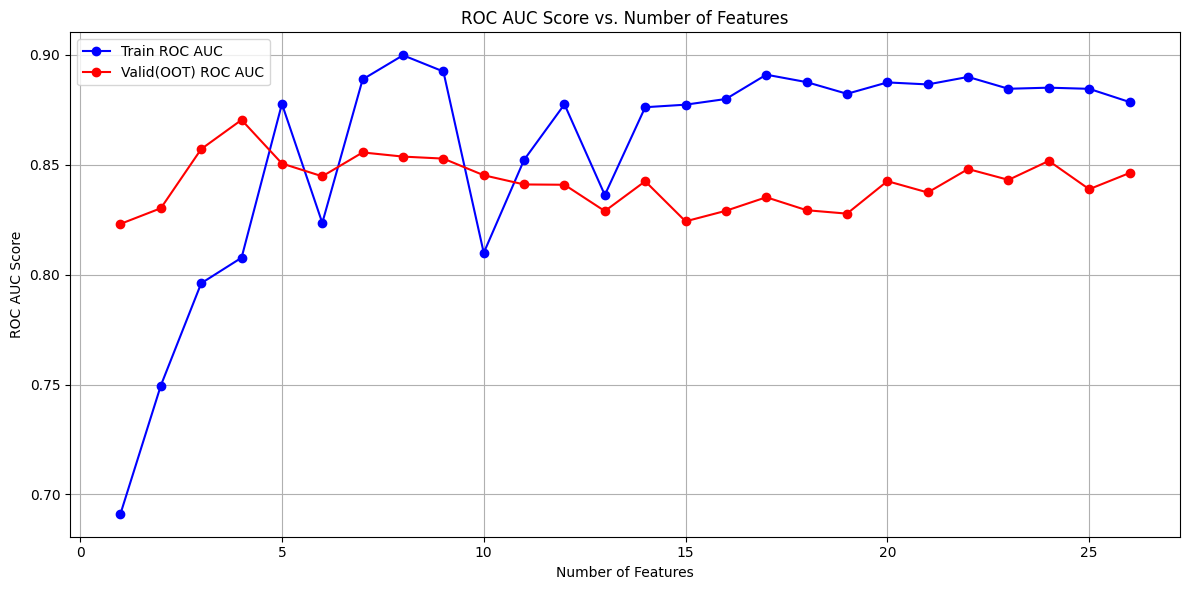

In [402]:

train_roc_aucs = [df[df['sample'] == 'Train']['roc_auc'].values[0] for df in history['metrics']]
valid_roc_aucs = [df[df['sample'] == 'Valid(OOT)']['roc_auc'].values[0] for df in history['metrics']]

num_features = history['num_feats']
plt.figure(figsize=(12, 6))
plt.plot(num_features, train_roc_aucs, marker='o', label='Train ROC AUC', color='blue')
plt.plot(num_features, valid_roc_aucs, marker='o', label='Valid(OOT) ROC AUC', color='red')
plt.title('ROC AUC Score vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('ROC AUC Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**по графику видно, что можно отобрать 5 или 7 фичей**

In [455]:
cols = history['sel_feats'][-1][:5].copy()
cat_features = model_df[cols].select_dtypes(include=['object']).columns.tolist()

In [456]:
clf = build_cb_model(model_df[train_mask][cols], model_df[train_mask].target,
                     model_df[valid_mask][cols], model_df[valid_mask].target, 
                     cat_features=cat_features, params=catboost_params)

0:	test: 0.6679693	best: 0.6679693 (0)	total: 7.98ms	remaining: 1.59s
50:	test: 0.8366633	best: 0.8366633 (50)	total: 255ms	remaining: 746ms
100:	test: 0.8473720	best: 0.8483463 (87)	total: 444ms	remaining: 435ms
150:	test: 0.8493509	best: 0.8493509 (150)	total: 624ms	remaining: 202ms
199:	test: 0.8504978	best: 0.8505825 (197)	total: 793ms	remaining: 0us

bestTest = 0.8505824861
bestIteration = 197

Shrink model to first 198 iterations.


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_26160\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.877716,0.104498,0.386207,0.440945,0.343558
1,Valid(OOT),0.850582,0.088364,0.285714,0.230216,0.376471
2,Test(OOT),0.829096,0.074838,0.177215,0.118644,0.350000


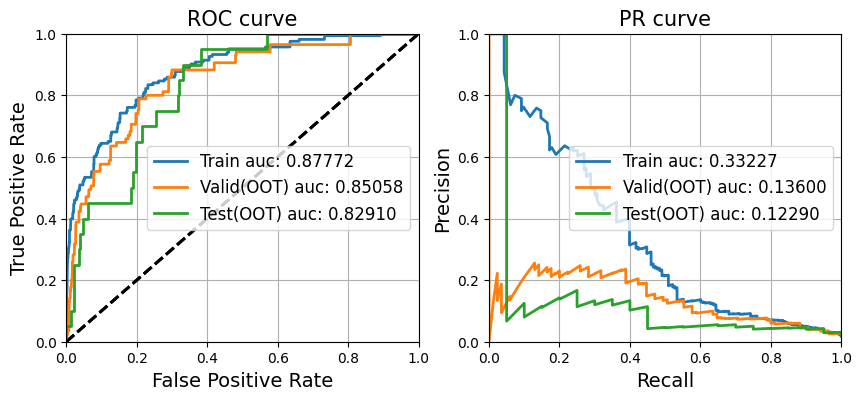

In [457]:
target_proba_sets = predict_proba_4eval_sets(clf, [(model_df[train_mask][cols], model_df[train_mask].target),
                     (model_df[valid_mask][cols], model_df[valid_mask].target), 
                     (model_df[oot_mask][cols], model_df[oot_mask].target)])

fig, metrics_df = evaluation_clf(target_proba_sets, ['Train', 'Valid(OOT)', 'Test(OOT)'], thres_method='J')

display(metrics_df)

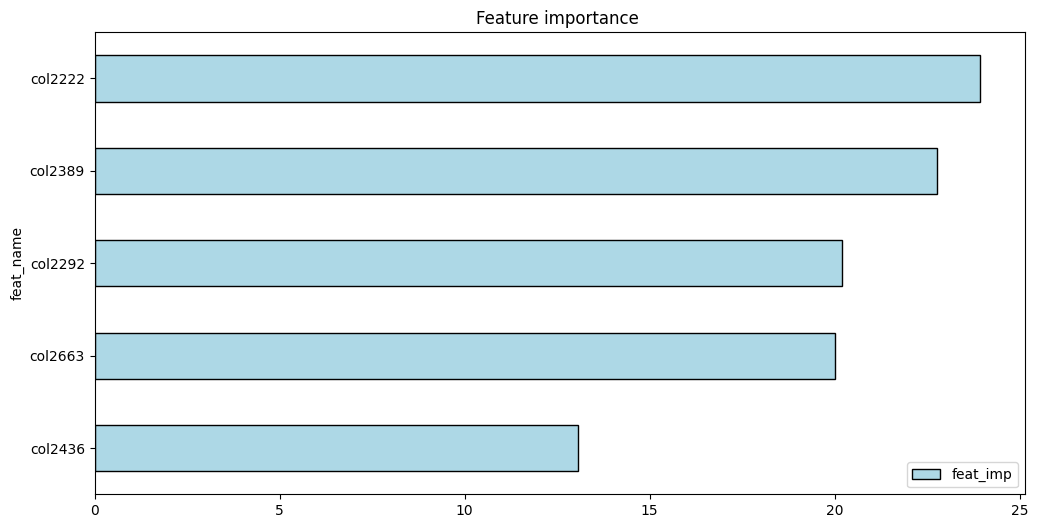

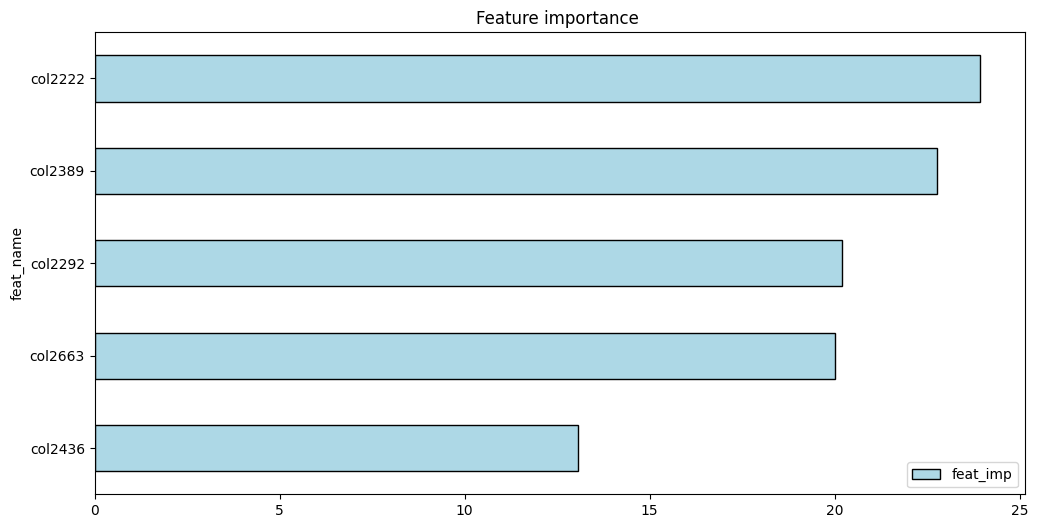

In [458]:
plot_feature_importance(clf)

### динамика roc auc по месяцам

In [459]:
model_df['proba'] = clf.predict_proba(model_df[cols])[:,1]

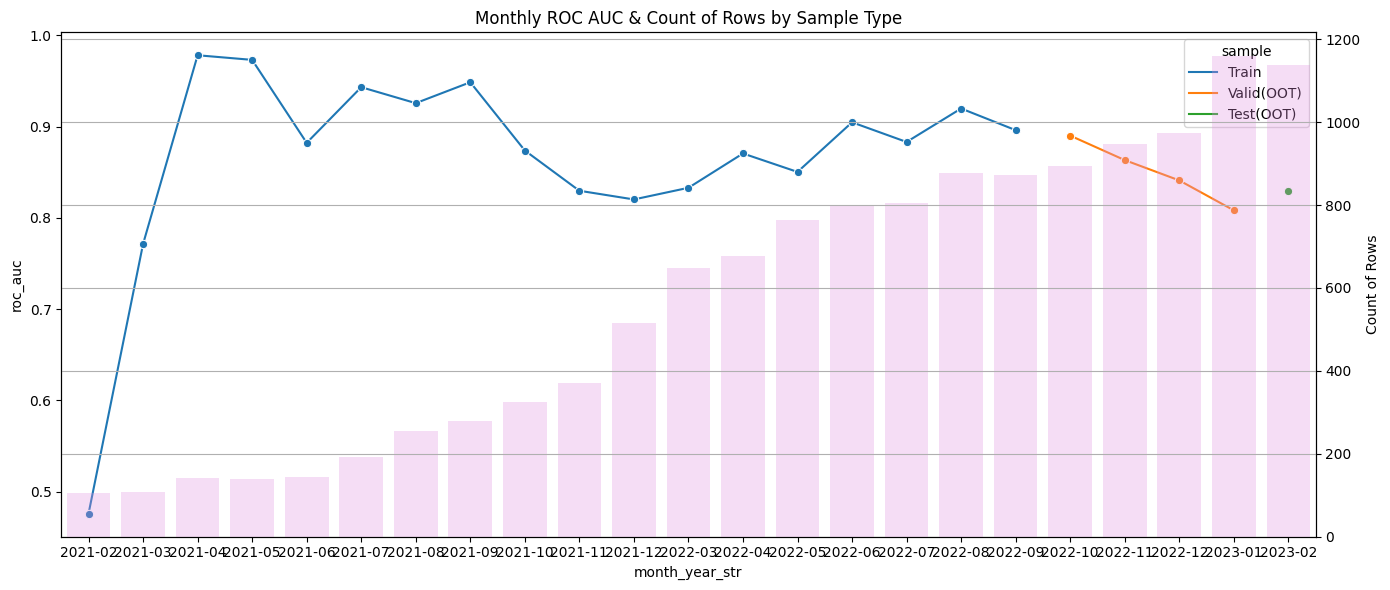

In [460]:
roc_df = model_df.groupby(['year_month', 'sample']).apply(lambda x: roc_auc_score(x['target'], x['proba'])).reset_index()
roc_df.columns = ['year_month', 'sample', 'roc_auc']
roc_df['month_year_str'] = roc_df['year_month'].astype(str)

# Calculate the count for each month and sample
count_df = model_df.groupby(['year_month', 'sample']).size().reset_index()
count_df.columns = ['year_month', 'sample', 'count']

# Merge the two dataframes on year_month and sample
roc_df = pd.merge(roc_df, count_df, on=['year_month', 'sample'])

# Convert year_month to string for plotting
roc_df['month_year_str'] = roc_df['year_month'].astype(str)

# Plotting using seaborn
plt.figure(figsize=(14, 6))

# Plot ROC AUC
sns.lineplot(data=roc_df, x='month_year_str', y='roc_auc', hue='sample', marker='o')

# Add secondary axis for counts
ax2 = plt.gca().twinx()
# sns.barplot(data=roc_df, x='month_year_str', y='count', ax=ax2, alpha=0.3)
sns.barplot(data=roc_df, x='month_year_str', y='count', ax=ax2, alpha=0.3, color="violet")
# Set labels, title, and legend
plt.gca().set_ylabel("ROC AUC")
ax2.set_ylabel("Count of Rows")
plt.gca().set_xlabel("Month")

plt.title("Monthly ROC AUC & Count of Rows by Sample Type")
plt.grid(True)

labels = roc_df['month_year_str'].unique()
ax2.set_xticklabels(labels=labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

### сохраним модель с отобранными 5 и 7 фичами

In [54]:
import joblib

In [55]:
feats = ['col2663', 'col2222', 'col2389', 'col2292', 'col2436']
cat_features = []

In [56]:
clf = build_cb_model(model_df[train_mask][feats], model_df[train_mask].target,
                     model_df[valid_mask][feats], model_df[valid_mask].target, 
                     cat_features=cat_features, params=catboost_params)

0:	test: 0.6612231	best: 0.6612231 (0)	total: 3.69ms	remaining: 735ms
50:	test: 0.8372594	best: 0.8372594 (50)	total: 183ms	remaining: 533ms
100:	test: 0.8461284	best: 0.8493237 (87)	total: 352ms	remaining: 345ms
150:	test: 0.8476353	best: 0.8493237 (87)	total: 520ms	remaining: 169ms
199:	test: 0.8475051	best: 0.8493237 (87)	total: 678ms	remaining: 0us

bestTest = 0.849323711
bestIteration = 87

Shrink model to first 88 iterations.


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_23228\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.845697,0.149912,0.274699,0.226190,0.349693
1,Valid(OOT),0.849324,0.144053,0.252492,0.175926,0.447059
2,Test(OOT),0.837377,0.173692,0.142857,0.250000,0.100000


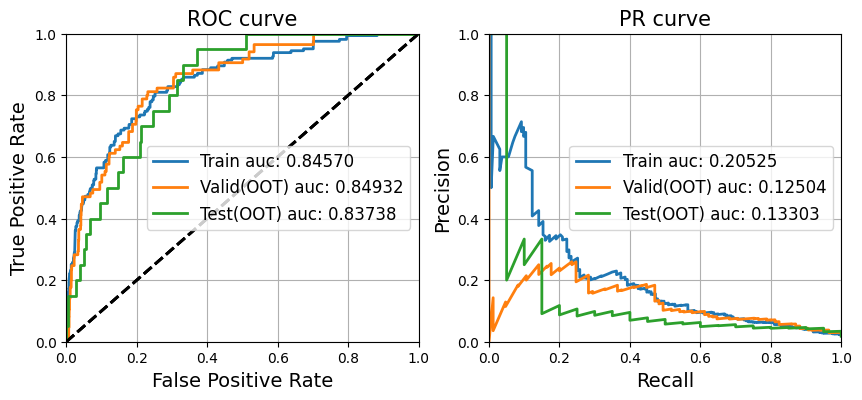

In [57]:
target_proba_sets = predict_proba_4eval_sets(clf, [(model_df[train_mask][feats], model_df[train_mask].target),
                     (model_df[valid_mask][feats], model_df[valid_mask].target), 
                     (model_df[oot_mask][feats], model_df[oot_mask].target)])

fig, metrics_df = evaluation_clf(target_proba_sets, ['Train', 'Valid(OOT)', 'Test(OOT)'], thres_method='J')

display(metrics_df)

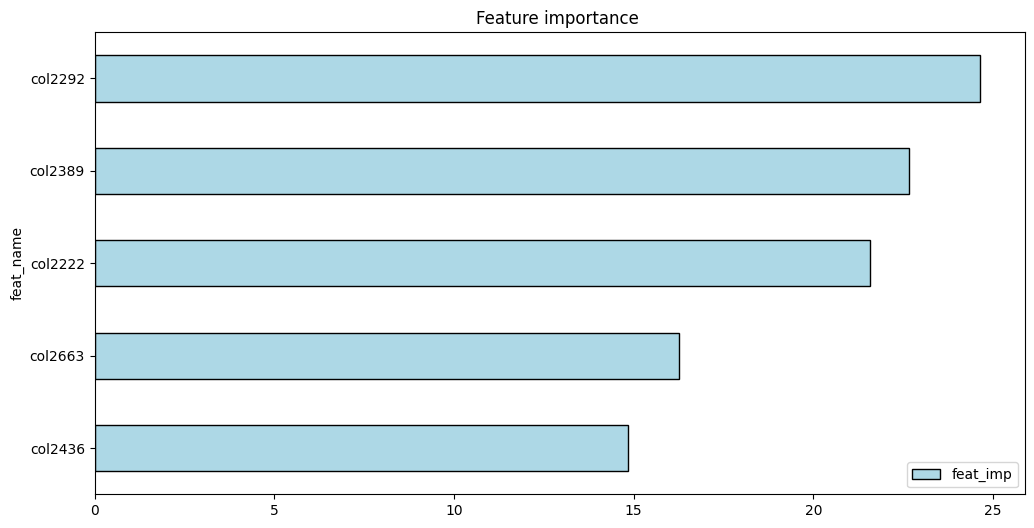

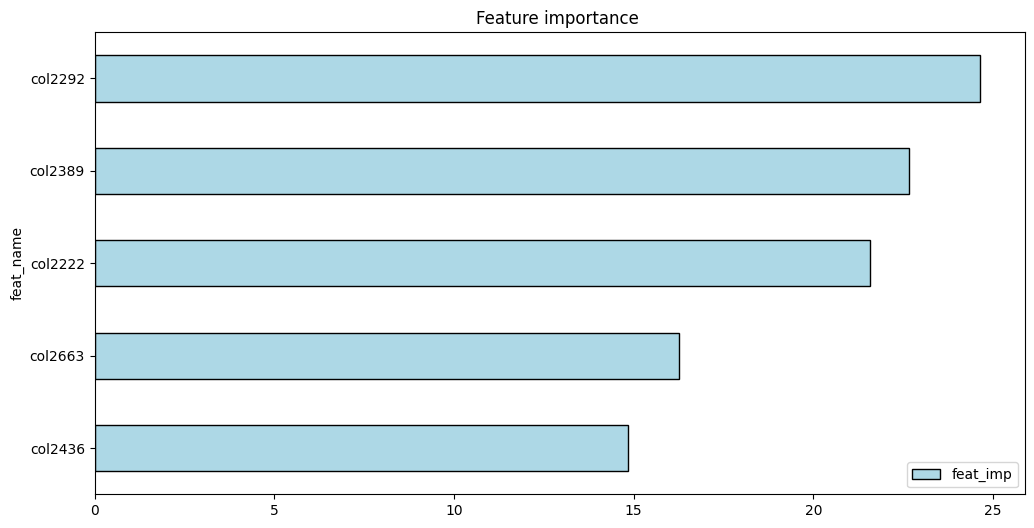

In [58]:
plot_feature_importance(clf)

In [59]:
joblib.dump(clf, '5_feats_tr.pkl')

['5_feats_tr.pkl']

In [60]:
feats_7 = ['col2663', 'col2222', 'col2389', 'col2292', 'col2436', 'col2461', 'col2318']
cat_features = []

In [61]:
clf = build_cb_model(model_df[train_mask][feats_7], model_df[train_mask].target,
                     model_df[valid_mask][feats_7], model_df[valid_mask].target, 
                     cat_features=cat_features, params=catboost_params)

0:	test: 0.6775236	best: 0.6775236 (0)	total: 6.33ms	remaining: 1.26s
50:	test: 0.8441857	best: 0.8453689 (39)	total: 184ms	remaining: 539ms
100:	test: 0.8519895	best: 0.8531363 (90)	total: 389ms	remaining: 381ms
150:	test: 0.8582713	best: 0.8597964 (145)	total: 556ms	remaining: 180ms
199:	test: 0.8593092	best: 0.8597964 (145)	total: 713ms	remaining: 0us

bestTest = 0.8597963568
bestIteration = 145

Shrink model to first 146 iterations.


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_23228\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)
C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_23228\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.876945,0.096376,0.365854,0.363636,0.368098
1,Valid(OOT),0.859796,0.082518,0.275862,0.204545,0.423529
2,Test(OOT),0.839033,0.068448,0.153846,0.090909,0.500000


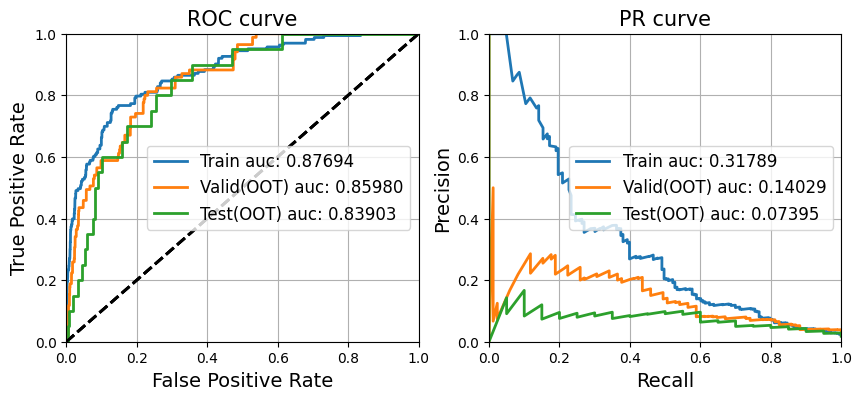

In [62]:
target_proba_sets = predict_proba_4eval_sets(clf, [(model_df[train_mask][feats_7], model_df[train_mask].target),
                     (model_df[valid_mask][feats_7], model_df[valid_mask].target), 
                     (model_df[oot_mask][feats_7], model_df[oot_mask].target)])

fig, metrics_df = evaluation_clf(target_proba_sets, ['Train', 'Valid(OOT)', 'Test(OOT)'], thres_method='J')

display(metrics_df)

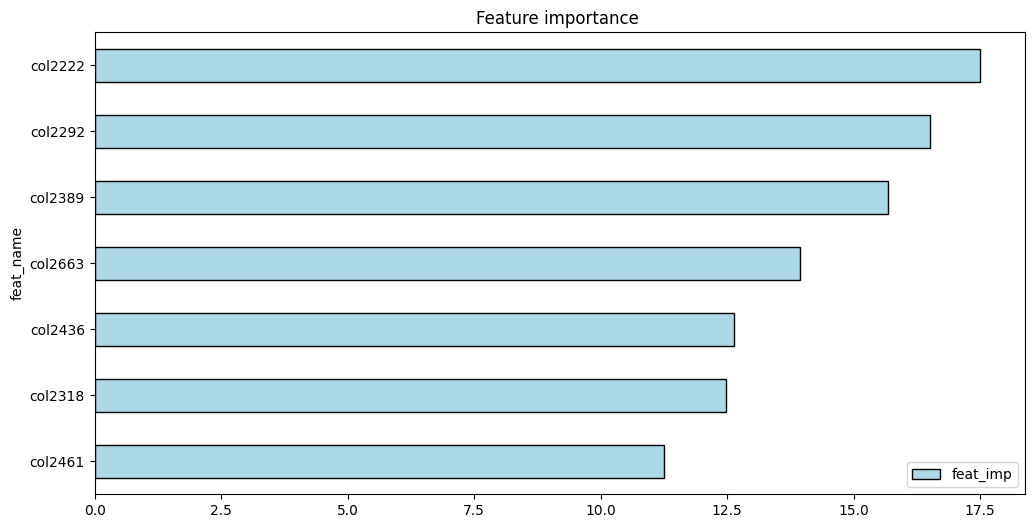

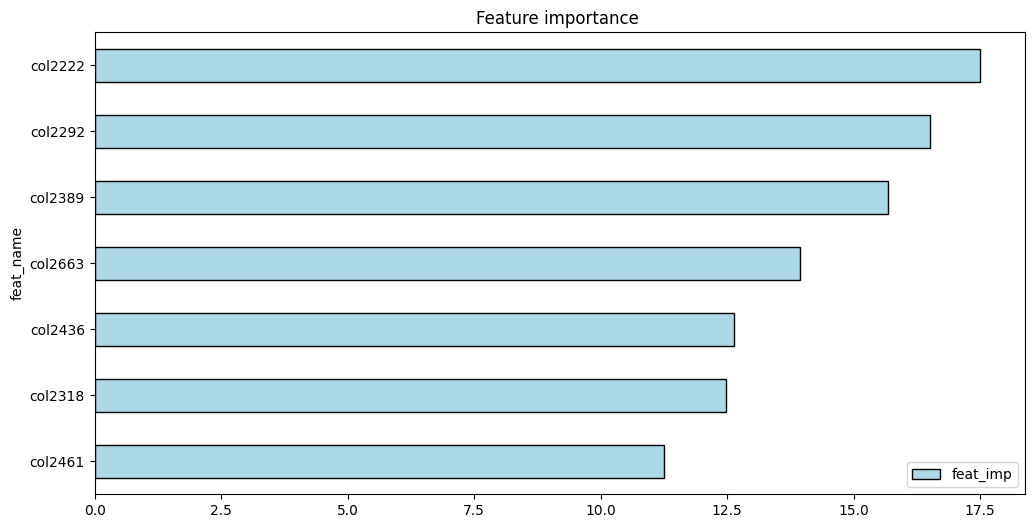

In [63]:
plot_feature_importance(clf)

In [64]:
joblib.dump(clf, '7_feats_tr.pkl')

['7_feats_tr.pkl']

### тюнинг моделей

In [67]:
import optuna

In [72]:
def objective(trial):
    params = {
        # "objective" : trial.suggest_categorical("objective", ["Logloss"]),
        "learning_rate" : trial.suggest_float("learning_rate", 1e-3, 2e-1),
        "l2_leaf_reg" : trial.suggest_float("l2_leaf_reg", 0.1, 12.0),
        "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.01, 0.1, log = True),
        "depth" : trial.suggest_int("depth", 2, 8),
        # "boosting_type" : trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf", 2, 50),
        "one_hot_max_size" : trial.suggest_int("one_hot_max_size", 2, 50),
        "iterations" : trial.suggest_int("iterations", 500, 3500),
        "eval_metric" : "AUC"
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log = True)

    model = CatBoostClassifier(
        loss_function = 'Logloss',
        random_seed = 15,
        task_type = 'CPU',
        use_best_model = True,
        verbose = False,
        **params
    )

    model.fit(
        model_df[train_mask][feats], model_df[train_mask].target,
        eval_set = (model_df[valid_mask][feats], model_df[valid_mask].target), 
        cat_features=cat_features
    )

    y_pred = model.predict_proba(model_df[valid_mask][feats])[:, 1]

    roc_auc = roc_auc_score(model_df[valid_mask].target, y_pred)

    return roc_auc

study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps = 5), direction = "maximize")
study.optimize(objective, n_trials = 100, timeout = 3600)

[I 2023-09-09 22:39:34,675] A new study created in memory with name: no-name-c7aea3ec-7134-4615-8023-884f487586ff
[I 2023-09-09 22:39:40,410] Trial 0 finished with value: 0.8264524328249819 and parameters: {'learning_rate': 0.019469060797300448, 'l2_leaf_reg': 6.086055173110571, 'colsample_bylevel': 0.05747909225737598, 'depth': 2, 'bootstrap_type': 'MVS', 'min_data_in_leaf': 9, 'one_hot_max_size': 43, 'iterations': 2991}. Best is trial 0 with value: 0.8264524328249819.
[I 2023-09-09 22:39:42,141] Trial 1 finished with value: 0.8325405470830307 and parameters: {'learning_rate': 0.034982179934585356, 'l2_leaf_reg': 8.963003630087142, 'colsample_bylevel': 0.09374219415334506, 'depth': 5, 'bootstrap_type': 'MVS', 'min_data_in_leaf': 22, 'one_hot_max_size': 21, 'iterations': 820}. Best is trial 1 with value: 0.8325405470830307.
[I 2023-09-09 22:39:44,132] Trial 2 finished with value: 0.8112427378358751 and parameters: {'learning_rate': 0.08035465524179722, 'l2_leaf_reg': 1.1849087804766176

In [74]:
pars = study.best_params

In [75]:
model = CatBoostClassifier(
    loss_function = 'Logloss',
    random_seed = 15,
    task_type = 'CPU',
    use_best_model = True,
    verbose = False,
    **pars
)

model.fit(
    model_df[train_mask][feats], model_df[train_mask].target,
    eval_set = (model_df[valid_mask][feats], model_df[valid_mask].target), 
    cat_features=cat_features
)

C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_23228\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)
C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_23228\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.842909,0.088161,0.294798,0.278689,0.312883
1,Valid(OOT),0.878705,0.098691,0.270588,0.270588,0.270588
2,Test(OOT),0.842346,0.054317,0.151261,0.090909,0.450000


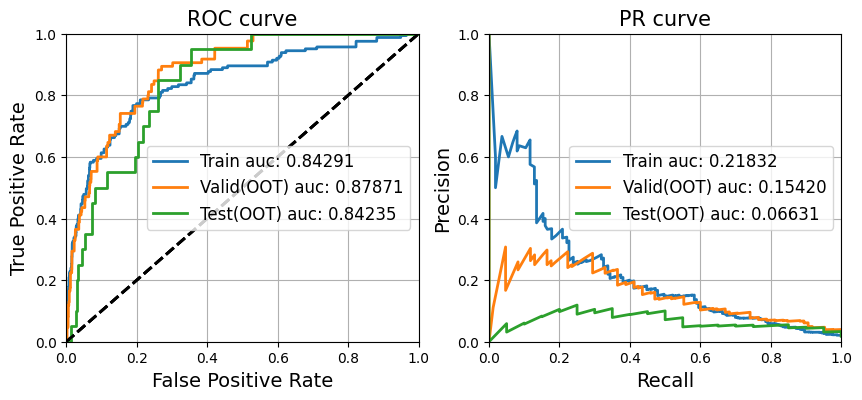

In [76]:
target_proba_sets = predict_proba_4eval_sets(model, [(model_df[train_mask][feats], model_df[train_mask].target),
                     (model_df[valid_mask][feats], model_df[valid_mask].target), 
                     (model_df[oot_mask][feats], model_df[oot_mask].target)])

fig, metrics_df = evaluation_clf(target_proba_sets, ['Train', 'Valid(OOT)', 'Test(OOT)'], thres_method='J')

display(metrics_df)

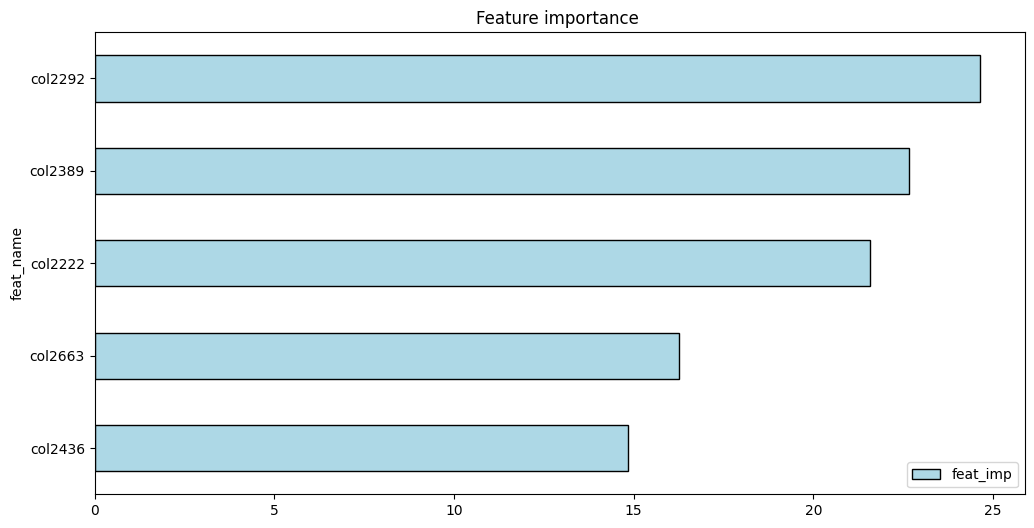

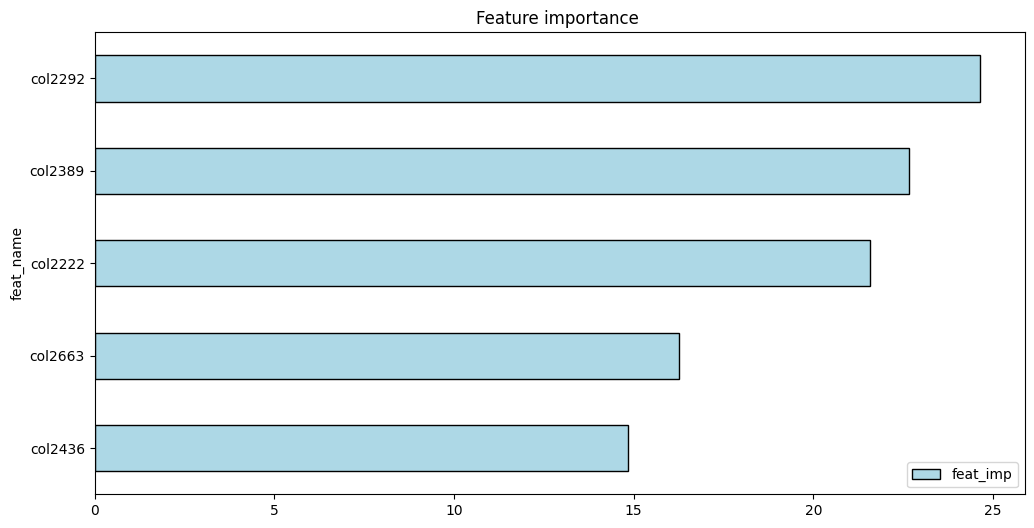

In [58]:
plot_feature_importance(clf)

In [78]:
joblib.dump(model, '5_feats_tr_tuned.pkl')

['5_feats_tr_tuned.pkl']

In [80]:
def objective(trial):
    params = {
        # "objective" : trial.suggest_categorical("objective", ["Logloss"]),
        "learning_rate" : trial.suggest_float("learning_rate", 1e-3, 2e-1),
        "l2_leaf_reg" : trial.suggest_float("l2_leaf_reg", 0.1, 12.0),
        "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.01, 0.1, log = True),
        "depth" : trial.suggest_int("depth", 2, 8),
        # "boosting_type" : trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf", 2, 50),
        "one_hot_max_size" : trial.suggest_int("one_hot_max_size", 2, 50),
        "iterations" : trial.suggest_int("iterations", 500, 3500),
        "eval_metric" : "AUC"
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log = True)

    model = CatBoostClassifier(
        loss_function = 'Logloss',
        random_seed = 15,
        task_type = 'CPU',
        use_best_model = True,
        verbose = False,
        **params
    )

    model.fit(
        model_df[train_mask][feats_7], model_df[train_mask].target,
        eval_set = (model_df[valid_mask][feats_7], model_df[valid_mask].target), 
        cat_features=cat_features
    )

    y_pred = model.predict_proba(model_df[valid_mask][feats_7])[:, 1]

    roc_auc = roc_auc_score(model_df[valid_mask].target, y_pred)

    return roc_auc

study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps = 5), direction = "maximize")
study.optimize(objective, n_trials = 100, timeout = 3600)

[I 2023-09-09 22:52:24,746] A new study created in memory with name: no-name-2cda411d-004e-4df7-8124-a03442456fb1
[I 2023-09-09 22:52:26,004] Trial 0 finished with value: 0.8174927378358751 and parameters: {'learning_rate': 0.0567150358066616, 'l2_leaf_reg': 10.290250686315405, 'colsample_bylevel': 0.017334533503717216, 'depth': 5, 'bootstrap_type': 'MVS', 'min_data_in_leaf': 7, 'one_hot_max_size': 27, 'iterations': 638}. Best is trial 0 with value: 0.8174927378358751.
[I 2023-09-09 22:52:31,266] Trial 1 finished with value: 0.8563498547567175 and parameters: {'learning_rate': 0.02038331697359111, 'l2_leaf_reg': 2.1815384826158977, 'colsample_bylevel': 0.026790987718038513, 'depth': 5, 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 17, 'one_hot_max_size': 41, 'iterations': 3124, 'bagging_temperature': 5.9160881919500525}. Best is trial 1 with value: 0.8563498547567175.
[I 2023-09-09 22:52:37,502] Trial 2 finished with value: 0.8466911764705882 and parameters: {'learning_rate': 0.161

In [81]:
pars = study.best_params

In [82]:
model = CatBoostClassifier(
    loss_function = 'Logloss',
    random_seed = 15,
    task_type = 'CPU',
    use_best_model = True,
    verbose = False,
    **pars
)

model.fit(
    model_df[train_mask][feats_7], model_df[train_mask].target,
    eval_set = (model_df[valid_mask][feats_7], model_df[valid_mask].target), 
    cat_features=cat_features
)

C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_23228\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.890047,0.088103,0.368876,0.347826,0.392638
1,Valid(OOT),0.860568,0.085999,0.277778,0.229008,0.352941
2,Test(OOT),0.839257,0.092121,0.181818,0.142857,0.250000


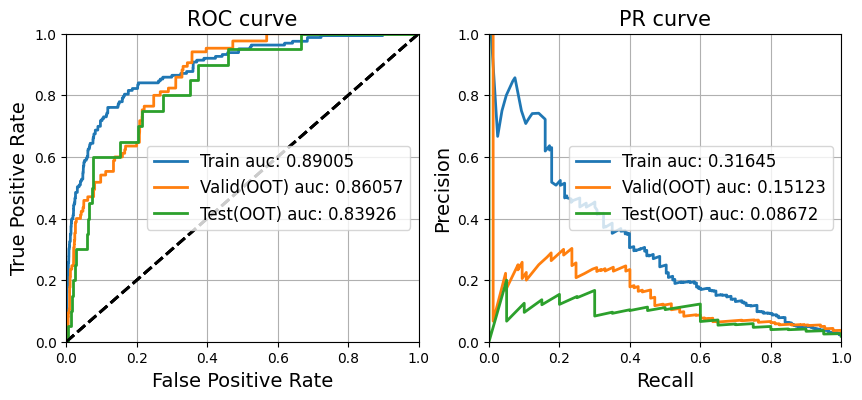

In [84]:
target_proba_sets = predict_proba_4eval_sets(model, [(model_df[train_mask][feats_7], model_df[train_mask].target),
                     (model_df[valid_mask][feats_7], model_df[valid_mask].target), 
                     (model_df[oot_mask][feats_7], model_df[oot_mask].target)])

fig, metrics_df = evaluation_clf(target_proba_sets, ['Train', 'Valid(OOT)', 'Test(OOT)'], thres_method='J')

display(metrics_df)

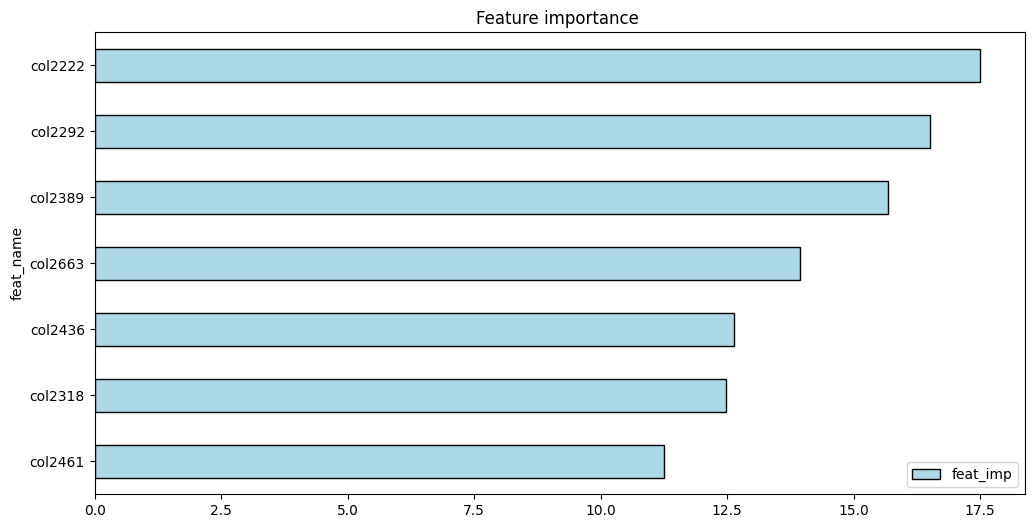

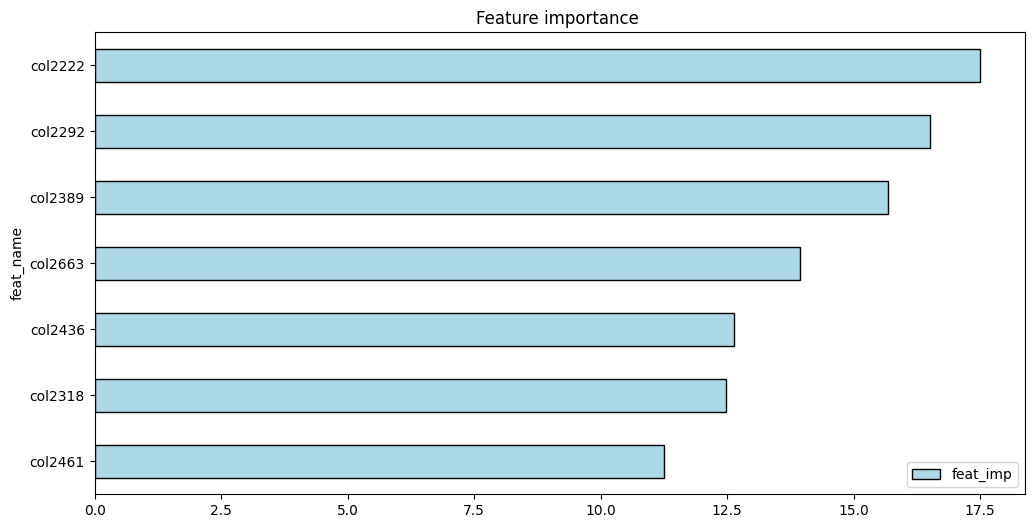

In [85]:
plot_feature_importance(clf)

In [86]:
joblib.dump(model, '7_feats_tr_tuned.pkl')

['7_feats_tr_tuned.pkl']